# Test notebook for scirpy usage
This notebook is the analog to the Colab created by Gregor S. for the demonstration of scirpy.datasets function usage:

https://colab.research.google.com/drive/15HIYGsSBHkDV399KSchv2QEyBzheL6fW?usp=sharing

In this notebook, the databases are being imported and converted to AnnData via Biocypher instead.

In [5]:
#import necessary packages with common abbreviation
import sys
sys.path.append('..')

import muon as mu
import numpy as np
import scanpy as sc

import scirpy as ir
import matplotlib as plt
from biocypher import BioCypher
from biocypher._deduplicate import Deduplicator
from tcr_epitope.adapters.iedb_adapter import IEDBAdapter
from tcr_epitope.adapters.mcpas_adapter import MCPASAdapter
from tcr_epitope.adapters.vdjdb_adapter import VDJDBAdapter
from tcr_epitope.adapters.utils import AnnDataKG


sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

# Data import and preprocessing

In [2]:
mdata = ir.datasets.wu2020_3k()
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ", "multichain"]))

/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/anndata/utils.py:354: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


Filtering chains...
Indexing VJ chains...


/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


Indexing VDJ chains...
build result array
Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


# Clonotype clustering

Computing sequence x sequence distance matrix for VJ sequences.
block size set to 50


100%|██████████| 496/496 [00:16<00:00, 30.25it/s]


Computing sequence x sequence distance matrix for VDJ sequences.
block size set to 50


100%|██████████| 496/496 [00:08<00:00, 60.41it/s]

Initializing lookup tables. 


Computing clonotype x clonotype distances.
Stored result in `mdata.obs["airr:cc_aa_alignment"]`.
Stored result in `mdata.obs["airr:cc_aa_alignment_size"]`.


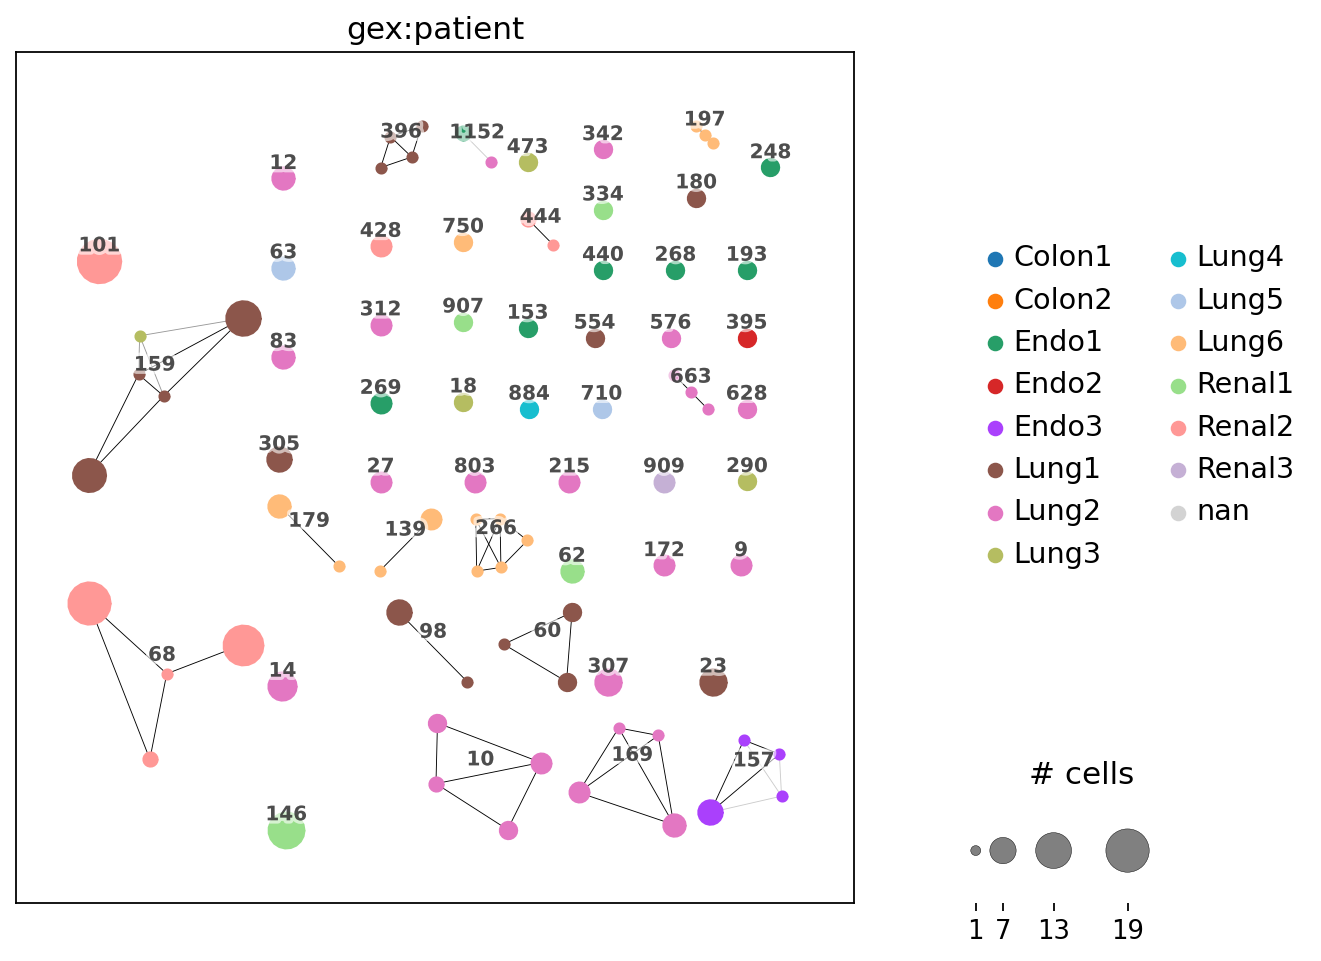

In [3]:
ir.pp.ir_dist(
    mdata,
    metric="alignment",
    sequence="aa",
    cutoff=15)

ir.tl.define_clonotype_clusters(mdata,
                                sequence="aa",
                                metric="alignment",
                                receptor_arms="all",
                                dual_ir="any")

#min_cells = 3 will only plot clonotype clusters with a size >= 3
ir.tl.clonotype_network(mdata, min_cells=3, sequence="aa", metric="alignment")

_ = ir.pl.clonotype_network(mdata, color="gex:patient", label_fontsize=9, panel_size=(7, 7), base_size=20)

# save figure as a png
#plt.savefig("clonotype_network.png", bbox_inches="tight")

# KG creation

In [4]:
# Before creating a KG, modify the FileDownload function from BioCypher, since the IEDB db cannot be accessed easily from the url:
# 403 Client Error: Forbidden for url
# Simple monkey patch of BioCypher's downloader
def patch_biocypher_downloader():
    from biocypher._get import Downloader
    
    # Store the original method
    original_retrieve = Downloader._retrieve
    
    def patched_retrieve(self, url, fname, path, known_hash=None):
        """Add custom headers to the request if it's for IEDB."""
        if "iedb.org" in url:
            import pooch
            import requests
            
            # Define custom downloader with headers
            def custom_downloader(url, output_file, pooch):
                headers = {
                    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                    'Referer': 'https://www.iedb.org/',
                    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
                    'Accept-Language': 'en-US,en;q=0.5',
                }
                response = requests.get(url, headers=headers, stream=True)
                response.raise_for_status()
                
                with open(output_file, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            
            # Use pooch with our custom downloader
            return pooch.retrieve(
                url=url,
                known_hash=known_hash,
                fname=fname,
                path=path,
                processor=pooch.Unzip() if fname.endswith('.zip') else None,
                downloader=custom_downloader,
                progressbar=True,
            )
        else:
            # Use the original method for other URLs
            return original_retrieve(self, url, fname, path, known_hash)
    
    # Apply the patch
    Downloader._retrieve = patched_retrieve
    print("BioCypher's downloader has been patched to handle IEDB URLs.")

# Apply the patch
patch_biocypher_downloader()


BioCypher's downloader has been patched to handle IEDB URLs.


In [6]:
# Create BioCypher instance
bc_anndata = BioCypher(cache_directory="../cache", biocypher_config_path="../config/biocypher_config.yaml",
    schema_config_path="../config/schema_config.yaml",)
# Create AnnDataKG instance
anndatakg = AnnDataKG(Deduplicator())

adapters = [
    VDJDBAdapter(bc_anndata, test = True),
    MCPASAdapter(bc_anndata, test = True),
    IEDBAdapter(bc_anndata, test = True),
]

for adapt in adapters:
    # Get nodes and edges from the adapter
    nodes = adapt.get_nodes()
    edges = adapt.get_edges()

    # You need to translate the tuples to BioCypher objects before adding them
    # Use BioCypher's translator for this
    translator = bc_anndata._get_translator()
    translated_nodes = translator.translate_entities(nodes)
    translated_edges = translator.translate_entities(edges)

    # Now add the translated entities to your AnnDataKG
    anndatakg.add_nodes(translated_nodes)
    anndatakg.add_edges(translated_edges)

# Get the AnnData object (assuming 
adata = anndatakg.get_kg()
print(adata)

INFO -- Running BioCypher with schema configuration from ../config/schema_config.yaml.
INFO -- Loading cache file ../cache/cache.json.
INFO -- Use cached version from ../cache/vdjdb_latest.
INFO -- Use cached version from ../cache/iedb_exact_matches_b28821a867027cba1b1a7712f25b2997.
INFO -- Use cached version from ../cache/iedb_exact_matches_85c988371107b04e9fe26ad932e693c5.
INFO -- Use cached version from ../cache/iedb_exact_matches_d5ba2348d21b9064945745b70c47beb4.
INFO -- Use cached version from ../cache/iedb_exact_matches_28f8152bffbf5328d42bf1785398212f.
INFO -- Use cached version from ../cache/iedb_exact_matches_f8f259efef8763c846f99b77b82fccb9.
INFO -- Use cached version from ../cache/iedb_substring_matches9c33bf13e1657149b8dd254335bf1d88.
INFO -- Use cached version from ../cache/mcpas_latest.


Mapping AA epitope sequences to IEDB IDs: exact matches...
Processing batch 1/5
Request URL: https://query-api.iedb.org/epitope_search?linear_sequence=in.(KLGGALQAK,NLVPMVATV,AVFDRKSDAK,RAKFKQL...
Processing batch 2/5
Request URL: https://query-api.iedb.org/epitope_search?linear_sequence=in.(RTATKQYNV,FLNRFTTTL,LMNVLTLVY,IMDQVPFS...
Processing batch 3/5
Request URL: https://query-api.iedb.org/epitope_search?linear_sequence=in.(GADGVGKSAL,GLALYYPSA,VYIGDPAQL,VSATAGT...
Processing batch 4/5
Request URL: https://query-api.iedb.org/epitope_search?linear_sequence=in.(HSNLNDATY,HMTEVVRHC,EFTVSGNIL,ILTSLLVL...
Processing batch 5/5
Request URL: https://query-api.iedb.org/epitope_search?linear_sequence=in.(RYPLTFGWCF,ELAEYLYNI,QIKVRVKMV,QTNPVTL...
Found 563 exact IEDB ID matches. Trying substring matches for 72 remaining epitopes...
Final results: 611 of 635 epitopes matched to IEDB IDs (96.2%)


/home/lera/tcr-epitope/notebooks/../tcr_epitope/adapters/mcpas_adapter.py:40: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  table = pd.read_csv(table_path, encoding="utf-8-sig")
INFO -- Use cached version from ../cache/iedb_exact_matches_ae8c13af603ee36791d606062e1dc50d.
INFO -- Use cached version from ../cache/iedb_exact_matches_b5f9d602060c2b9c77097a5665e80208.
INFO -- Use cached version from ../cache/iedb_substring_matchesf58924cabbf0775a7c7669aeca029fcf.
INFO -- Use cached version from ../cache/iedb_latest.


Mapping AA epitope sequences to IEDB IDs: exact matches...
Processing batch 1/2
Request URL: https://query-api.iedb.org/epitope_search?linear_sequence=in.(NONE,GILGFVFTL,GLCTLVAML,TPRVTGGGAM,LP...
Processing batch 2/2
Request URL: https://query-api.iedb.org/epitope_search?linear_sequence=in.(FMYSDFHFI,ALVGAIPSI,LIFNMFYWI,EPLPQGQL...
Found 154 exact IEDB ID matches. Trying substring matches for 15 remaining epitopes...
Final results: 161 of 169 epitopes matched to IEDB IDs (95.3%)


/home/lera/tcr-epitope/notebooks/../tcr_epitope/adapters/iedb_adapter.py:56: DtypeWarning: Columns (2,10,12,13,14,15,16,17,18,19,20,21,22,23,24,29,30,35,36,41,42,43,44,45,46,47,48,49,50,51,52,53,58,59,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  tcr_table = pd.read_csv(tcr_table_path, header=[0, 1])
/home/lera/tcr-epitope/notebooks/../tcr_epitope/adapters/iedb_adapter.py:61: DtypeWarning: Columns (14,18,43) have mixed types. Specify dtype option on import or set low_memory=False.
  bcr_table = pd.read_csv(bcr_table_path, header=[0, 1])
INFO -- Loading ontologies...
INFO -- Instantiating OntologyAdapter class for https://github.com/biolink/biolink-model/raw/v3.2.1/biolink-model.owl.ttl.
WARNING -- Duplicate node type tra sequence found. 
WARNING -- Duplicate node type trb sequence found. 
WARNING -- Duplicate node type epitope found. 
WARNING -- Duplicate edge type t cell receptor sequence to epitope association found. 
WARNING -- Duplicate edge typ

Processing epitope associations
Processing paired TCRs
Processing unpaired TCRs
Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
AnnData object with n_obs × n_vars = 33757 × 0
    obs: 'IEDB_ID', 'MHC_class', 'MHC_gene_1', 'MHC_gene_2', 'antigen_name', 'antigen_organism', 'chain_1_organism', 'data_source', 'is_paired', 'protein'
    uns: 'scirpy_version', 'chain_indices', 'DB'
    obsm: 'airr', 'chain_indices'


In [7]:
ir.get.airr(adata, airr_variable = ["v_call","j_call", "junction_aa"], chain = ["VDJ_1"]).head(5)

,VDJ_1_v_call,VDJ_1_j_call,VDJ_1_junction_aa
cell_id,,,
tra:CAVDNNNDMRF-trb:CASSPRGDSGNTIYF,TRBV18,TRBJ1-3,CASSPRGDSGNTIYF
tra:NONE-trb:CASSLGLALYNEQFF,TRBV6-6,None,CASSLGLALYNEQFF
tra:CAGSRGGSQGNLIF-trb:CSVEGASGRGDTQYF,TRBV29-1,TRBJ2-3,CSVEGASGRGDTQYF
tra:NONE-trb:CASSRDNGELFF,TRBV5-4,None,CASSRDNGELFF
tra:CALSGNTPLVF-trb:CASSYSGSGADTQYF,TRBV6-2,TRBJ1-93,CASSYSGSGADTQYF


Index(['IEDB_ID', 'MHC_class', 'MHC_gene_1', 'MHC_gene_2', 'antigen_name',
       'antigen_organism', 'chain_1_organism', 'data_source', 'is_paired',
       'protein', 'VDJ_1_j_call'],
      dtype='object')


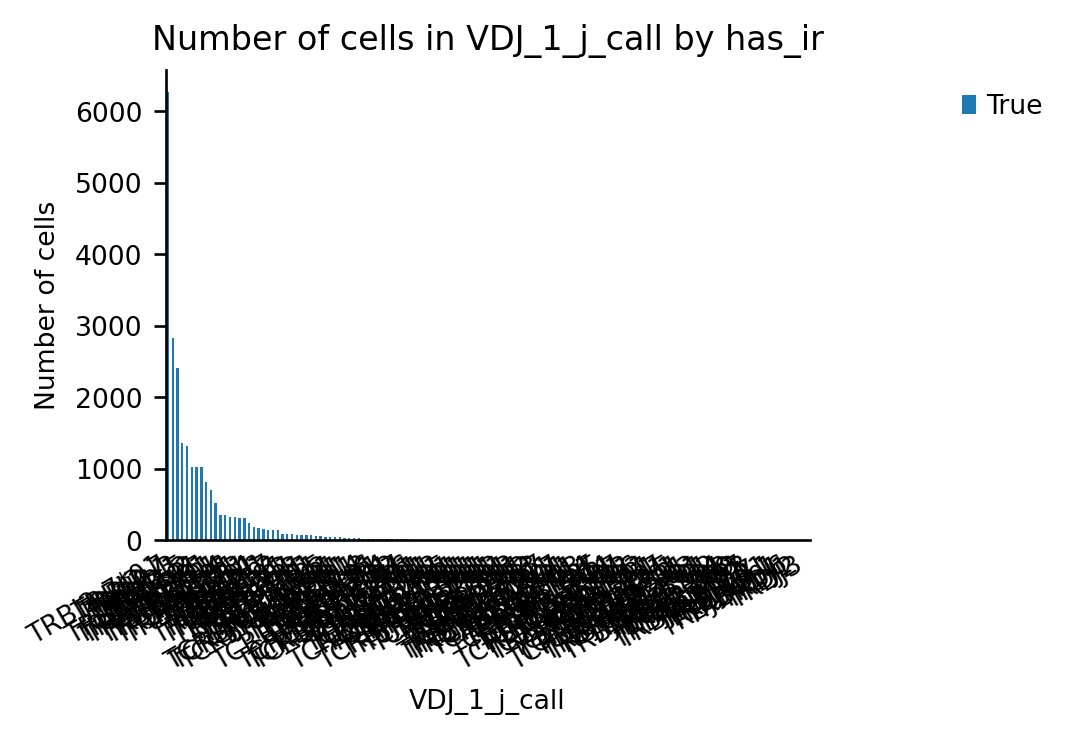

In [8]:
with ir.get.airr_context(adata, "j_call", "VDJ_1"):
    print(adata.obs.columns)
    _= ir.pl.group_abundance(adata, groupby="VDJ_1_j_call", max_cols = 0)
    # plt.xticks(rotation=50, ha='right')

In [9]:
ir.pp.ir_dist(mdata, adata, metric="fastalignment", sequence="aa", cutoff = 10)

Computing sequence x sequence distance matrix for VJ sequences.
block size set to 126


100%|██████████| 1066/1066 [00:08<00:00, 130.54it/s]


Computing sequence x sequence distance matrix for VDJ sequences.
block size set to 205


100%|██████████| 1056/1056 [00:22<00:00, 46.17it/s] 


In [10]:
ir.tl.ir_query(
    mdata,
    adata,
    metric="fastalignment",
    sequence="aa",
    receptor_arms="VDJ",
    dual_ir="primary_only",
)

Initializing lookup tables. 


Computing clonotype x clonotype distances.
Stored IR distance matrix in `adata.uns["ir_query_BioCypher_KG_aa_fastalignment"]`.


In [11]:
ir.tl.ir_query_annotate(
    mdata,
    adata,
    metric="fastalignment",
    sequence="aa",
    strategy = "most-frequent",
    include_ref_cols=["antigen_name"],
)

  0%|          | 0/702 [00:00<?, ?it/s]/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/scirpy/tl/_ir_query.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return values[0]
100%|██████████| 702/702 [00:00<00:00, 2346.89it/s]

Stored result in `mdata.obs["airr:antigen_name"]`.


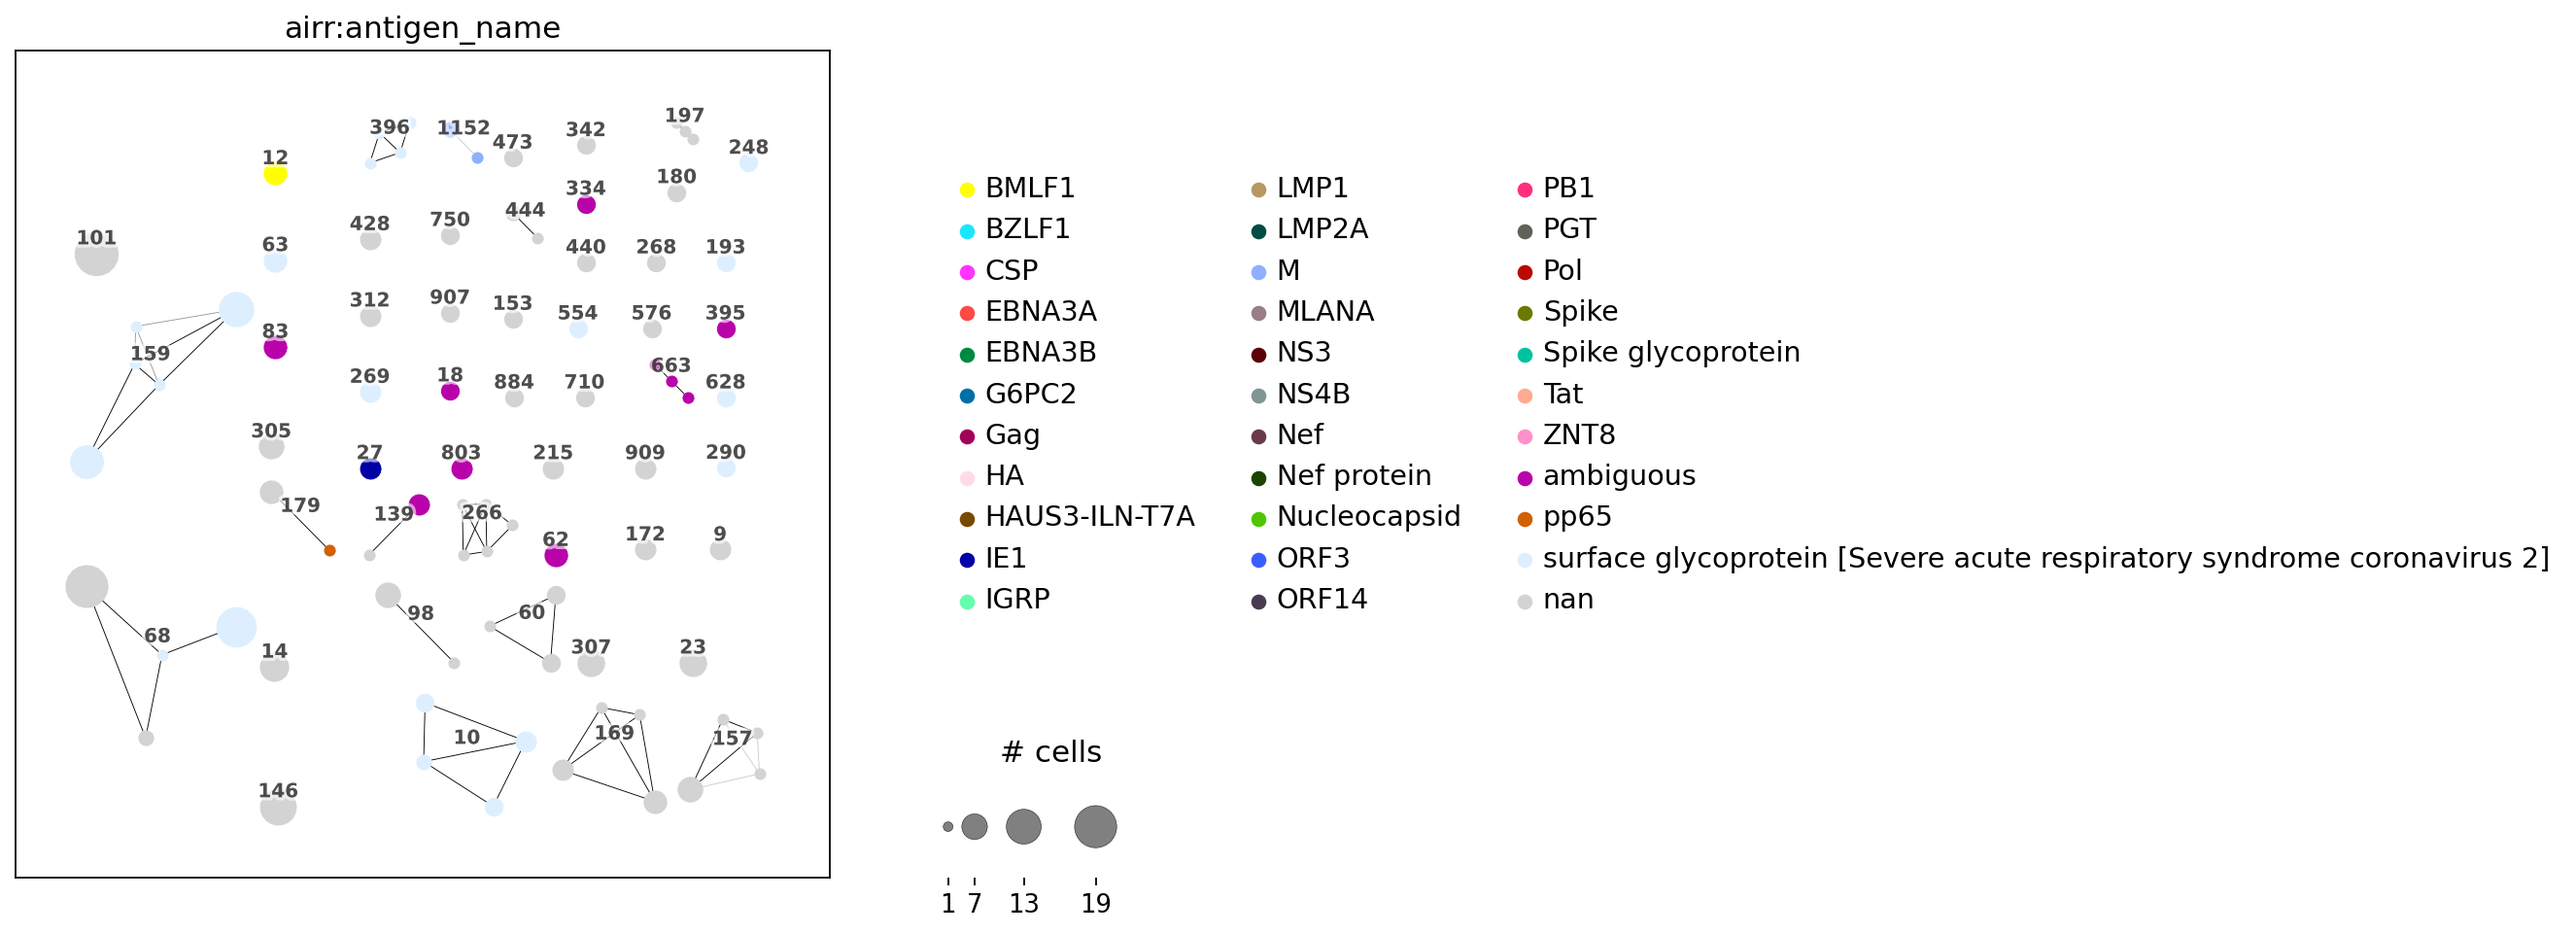

In [12]:
_=ir.pl.clonotype_network(mdata, color="airr:antigen_name", label_fontsize=9, panel_size=(7, 7), base_size=20)